R&D PORTFOLIO ANALYSIS
Sample Period: 1980-2022

STEP 1: CONNECTING TO WRDS


Enter your WRDS username [nathanarimilli]: nathan_arimilli
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Successfully connected to WRDS

STEP 2: RETRIEVING COMPUSTAT DATA
✓ Retrieved 180,934 firm-year observations
  - Firms with R&D: 82,229
  - Firms without R&D: 98,705

STEP 3: RETRIEVING CCM LINK TABLE
✓ Retrieved 32,849 GVKEY-PERMNO links

STEP 4: MERGING COMPUSTAT WITH CCM
✓ Matched 207,257 Compustat-CCM observations (before date filtering)

STEP 5: PREPARING R&D INDICATOR FOR T-1 MERGE
✓ Compustat-CCM data prepared: 207,257 observations

R&D distribution:
has_rd
0    112534
1     94723
Name: count, dtype: int64

STEP 6: RETRIEVING CRSP MONTHLY STOCK DATA
✓ Retrieved 2,654,739 stock-month observations

STEP 6B: RETRIEVING DELISTING RETURNS
✓ Retrieved 23,997 delisting events
  - Delisting events in sample: 2,195

STEP 6C: ADJUSTING RETURNS FOR DELISTING
  - After removing NA returns: 2,631,186 (23,553 removed)
✓ Returns adjusted for de

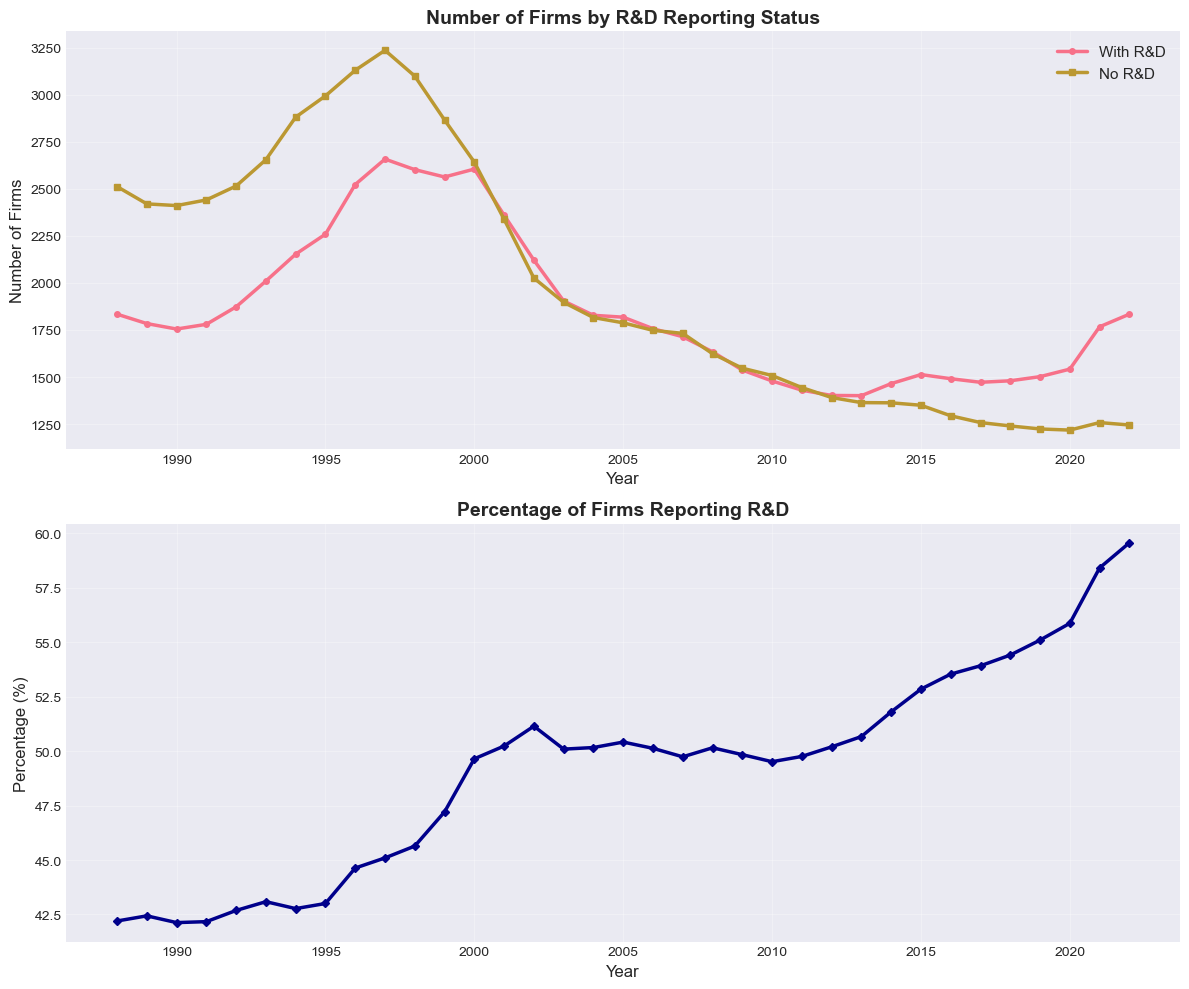

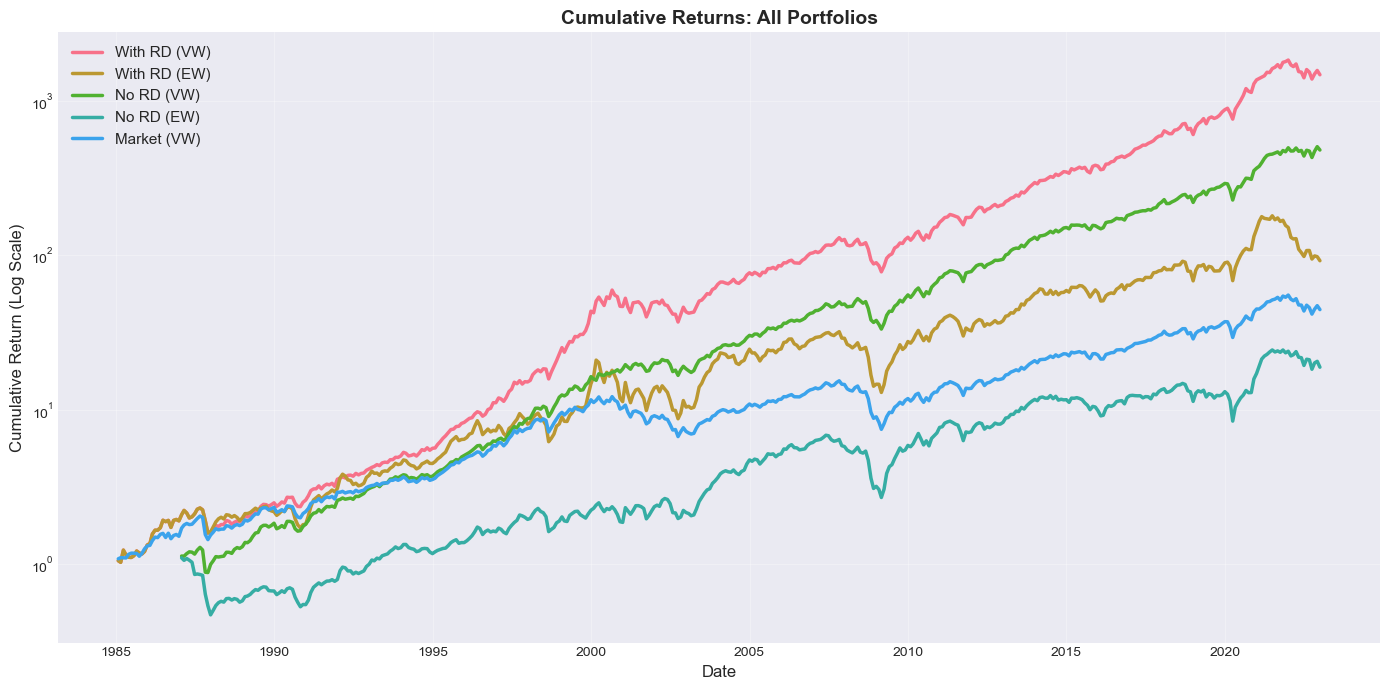

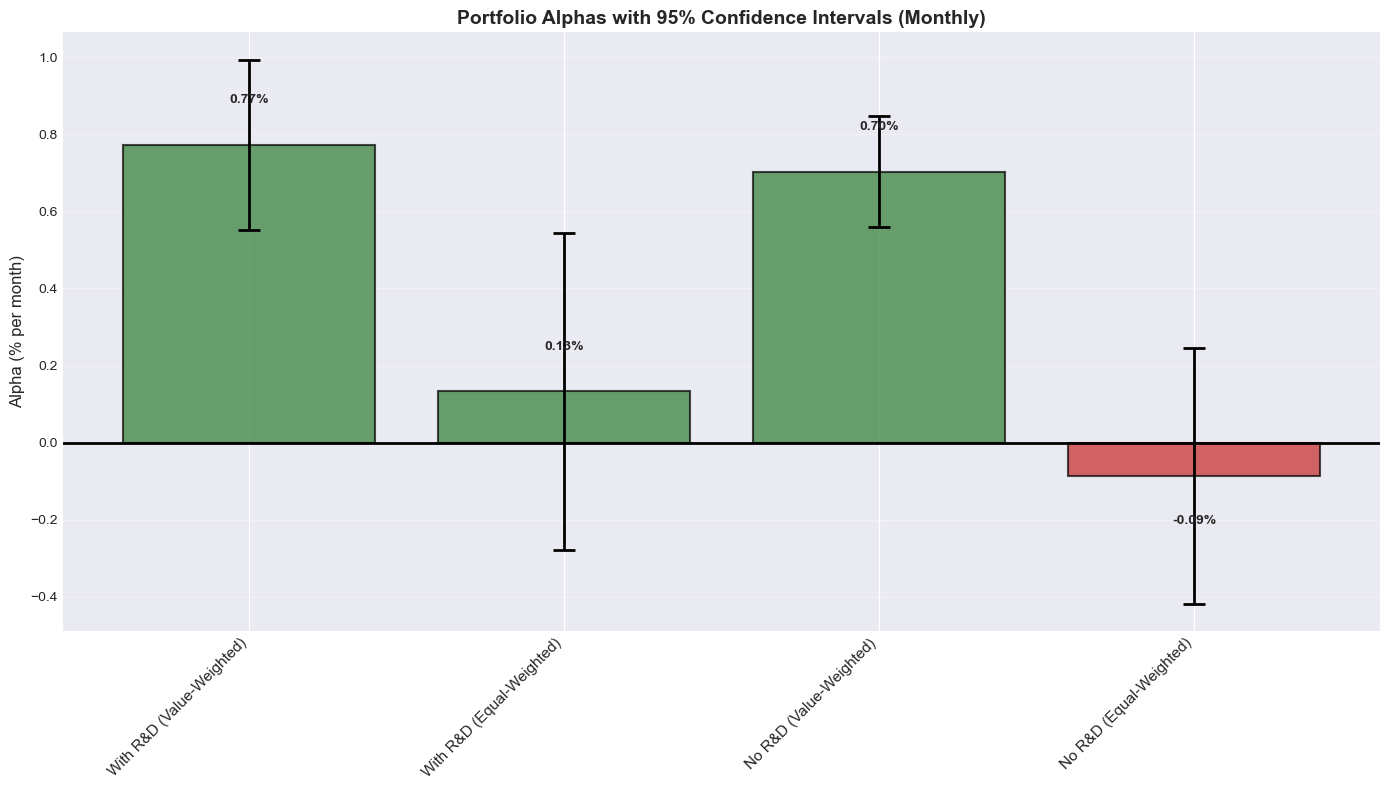

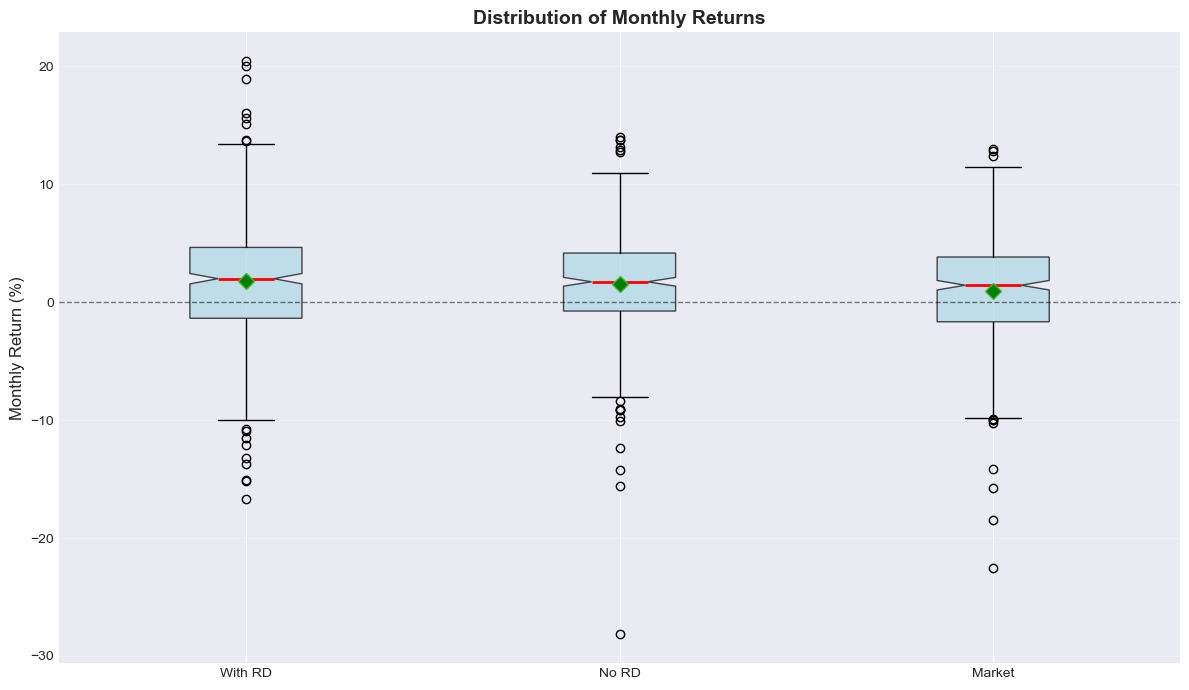


ANALYSIS COMPLETE!

Key Findings:
                Portfolio  Alpha (% monthly)  Alpha (% annual)  Std Error (% monthly)  t-statistic      p-value     Beta       R²  N (months)
With R&D (Value-Weighted)           0.773135          9.277622               0.112766     6.856115 2.320230e-11 1.059682 0.802045         456
With R&D (Equal-Weighted)           0.132840          1.594084               0.209865     0.632980 5.270652e-01 1.265360 0.625181         456
  No R&D (Value-Weighted)           0.702665          8.431976               0.073369     9.577093 8.023754e-20 0.919444 0.884326         432
  No R&D (Equal-Weighted)          -0.086768         -1.041222               0.169430    -0.512120 6.088300e-01 1.100089 0.672372         432



In [6]:
"""
R&D Portfolio Analysis - Simplified Version
Empirical Finance Project

Analyzes the relationship between R&D reporting and stock returns by constructing
portfolios of firms with and without reported R&D expenditure, computing alphas
relative to the CRSP value-weighted index.

This version uses the simple, correct approach: merge on year with t-1 R&D

Author: Nathan Arimilli
Date: January 2026
"""

import warnings
import sys
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import wrds
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("R&D PORTFOLIO ANALYSIS")
print("="*80)
print("Sample Period: 1980-2022")
print("="*80)

# ============================================================================
# STEP 1: CONNECT TO WRDS
# ============================================================================

print("\n" + "="*80)
print("STEP 1: CONNECTING TO WRDS")
print("="*80)

try:
    db = wrds.Connection()
    print("✓ Successfully connected to WRDS")
except Exception as e:
    print(f"✗ Failed to connect to WRDS: {e}")
    sys.exit(1)

# ============================================================================
# STEP 2: PULL COMPUSTAT DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 2: RETRIEVING COMPUSTAT DATA")
print("="*80)

compustat = db.raw_sql("""
    select gvkey, datadate, fyear, sich, xrd, at, csho, prcc_f
    from comp.funda
    where datadate between '01/01/1979' and '12/31/2022'
    and indfmt = 'INDL'
    and datafmt = 'STD'
    and popsrc = 'D'
    and consol = 'C'
    and curcd = 'USD'
    and fic = 'USA'
    and exchg between 11 and 19
    and (sich < 6000 or sich > 6999)
    and sich != 2834
""", date_cols=['datadate'])

print(f"✓ Retrieved {len(compustat):,} firm-year observations")

# Create R&D indicator
compustat['has_rd'] = ((compustat['xrd'].notna()) & (compustat['xrd'] > 0)).astype(int)

# Calculate market equity from Compustat
compustat['me_comp'] = compustat['csho'] * compustat['prcc_f']

print(f"  - Firms with R&D: {compustat['has_rd'].sum():,}")
print(f"  - Firms without R&D: {(1-compustat['has_rd']).sum():,}")

# ============================================================================
# STEP 3: GET CCM LINK TABLE
# ============================================================================

print("\n" + "="*80)
print("STEP 3: RETRIEVING CCM LINK TABLE")
print("="*80)

ccm = db.raw_sql("""
    select gvkey, lpermno as permno, linkdt, linkenddt
    from crsp.ccmxpf_lnkhist
    where linktype in ('LU', 'LC')
    and linkprim in ('P', 'C')
""", date_cols=['linkdt', 'linkenddt'])

# Handle missing linkenddt (active links)
ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.Timestamp('2099-12-31'))

print(f"✓ Retrieved {len(ccm):,} GVKEY-PERMNO links")

# ============================================================================
# STEP 4: MERGE COMPUSTAT WITH CCM
# ============================================================================

print("\n" + "="*80)
print("STEP 4: MERGING COMPUSTAT WITH CCM")
print("="*80)

comp_ccm = pd.merge(compustat, ccm, on='gvkey', how='inner')

print(f"✓ Matched {len(comp_ccm):,} Compustat-CCM observations (before date filtering)")

# Create year variable BEFORE filtering
# We need this for the year-based merge with CRSP
comp_ccm['year'] = comp_ccm['fyear']

# ============================================================================
# STEP 5: PREPARE R&D INDICATOR (NO SHIFT NEEDED)
# ============================================================================

print("\n" + "="*80)
print("STEP 5: PREPARING R&D INDICATOR FOR T-1 MERGE")
print("="*80)

# We DON'T need to shift here because we'll use comp_year = year - 1 in the merge
# The comp_year logic handles the t-1 relationship

# Create year variable for merging
comp_ccm['year'] = comp_ccm['fyear']

print(f"✓ Compustat-CCM data prepared: {len(comp_ccm):,} observations")
print(f"\nR&D distribution:")
print(comp_ccm['has_rd'].value_counts().sort_index())

# ============================================================================
# STEP 6: PULL CRSP DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 6: RETRIEVING CRSP MONTHLY STOCK DATA")
print("="*80)

crsp = db.raw_sql("""
    select a.permno, a.date, a.ret, a.retx, a.shrout, a.prc, b.shrcd, b.exchcd, b.hsiccd
    from crsp.msf as a
    left join crsp.msenames as b
    on a.permno = b.permno
    and b.namedt <= a.date
    and a.date <= b.nameendt
    where a.date between '01/01/1980' and '12/31/2022'
    and b.shrcd in (10, 11)
    and b.exchcd in (1, 2, 3)
""", date_cols=['date'])

print(f"✓ Retrieved {len(crsp):,} stock-month observations")

# CREATE JDATE IMMEDIATELY (needed for delisting merge)
crsp['jdate'] = crsp['date'] + MonthEnd(0)

# ============================================================================
# STEP 6B: PULL DELISTING RETURNS (SURVIVORSHIP BIAS CORRECTION)
# ============================================================================

print("\n" + "="*80)
print("STEP 6B: RETRIEVING DELISTING RETURNS")
print("="*80)

# Pull delisting returns from CRSP
delist = db.raw_sql("""
    select permno, dlstdt, dlret
    from crsp.msedelist
    where dlstdt between '01/01/1980' and '12/31/2022'
""", date_cols=['dlstdt'])

print(f"✓ Retrieved {len(delist):,} delisting events")

# Align delisting date to month-end
delist['jdate'] = delist['dlstdt'] + MonthEnd(0)

# Merge with CRSP
crsp = crsp.merge(delist[['permno', 'jdate', 'dlret']], 
                  on=['permno', 'jdate'], 
                  how='left')

print(f"  - Delisting events in sample: {crsp['dlret'].notna().sum():,}")

# ============================================================================
# STEP 6C: ADJUST RETURNS FOR DELISTING
# ============================================================================

print("\n" + "="*80)
print("STEP 6C: ADJUSTING RETURNS FOR DELISTING")
print("="*80)

# Convert to numeric
crsp['ret'] = pd.to_numeric(crsp['ret'], errors='coerce')
crsp['dlret'] = pd.to_numeric(crsp['dlret'], errors='coerce')

# Remove NA returns
initial_count = len(crsp)
crsp = crsp[crsp['ret'].notna()]
print(f"  - After removing NA returns: {len(crsp):,} ({initial_count - len(crsp):,} removed)")

# Compound returns with delisting returns
# Formula: (1 + ret) × (1 + dlret) - 1
crsp['ret'] = np.where(
    crsp['dlret'].notna(),
    (1 + crsp['ret']) * (1 + crsp['dlret']) - 1,
    crsp['ret']
)

delist_count = crsp['dlret'].notna().sum()
avg_dlret = crsp[crsp['dlret'].notna()]['dlret'].mean() if delist_count > 0 else 0

print(f"✓ Returns adjusted for delisting")
print(f"  - Observations with delisting adjustment: {delist_count:,}")
print(f"  - Average delisting return (when present): {avg_dlret*100:.2f}%")

# Clean up
crsp = crsp.drop(columns=['dlret'], errors='ignore')

# ============================================================================
# CONTINUE WITH EXISTING CLEANING (returns < -100%, SIC filters, etc.)
# ============================================================================

# Remove returns < -100%
initial_count = len(crsp)
crsp = crsp[crsp['ret'] > -1.0]
print(f"  - After removing returns < -100%: {len(crsp):,} ({initial_count - len(crsp):,} removed)")

# Apply SIC exclusions
initial_count = len(crsp)
crsp_with_sic = crsp[crsp['hsiccd'].notna()].copy()
crsp_no_sic = crsp[crsp['hsiccd'].isna()].copy()

crsp_with_sic = crsp_with_sic[~crsp_with_sic['hsiccd'].between(6000, 6999)]
crsp_with_sic = crsp_with_sic[crsp_with_sic['hsiccd'] != 2834]

crsp = pd.concat([crsp_with_sic, crsp_no_sic], ignore_index=True)
print(f"  - After SIC exclusions: {len(crsp):,} ({initial_count - len(crsp):,} removed)")

# Clean identifiers
crsp['permno'] = crsp['permno'].astype(int)

# NOTE: jdate already created above (before delisting merge)
# So we can skip: crsp['jdate'] = crsp['date'] + MonthEnd(0)

# Calculate market equity
# prc can be negative (bid-ask average), so take absolute value
# shrout is in thousands, so multiply by 1000
crsp['prc'] = crsp['prc'].abs()
crsp['shrout'] = crsp['shrout'] * 1000
crsp['me'] = crsp['prc'] * crsp['shrout']

# Create year and month variables
crsp['year'] = crsp['jdate'].dt.year
crsp['month'] = crsp['jdate'].dt.month

print(f"\n✓ Final CRSP sample: {len(crsp):,} observations")
print(f"  - Unique stocks: {crsp['permno'].nunique():,}")

# ============================================================================
# STEP 7: MERGE CRSP WITH COMPUSTAT
# ============================================================================

print("\n" + "="*80)
print("STEP 7: MERGING CRSP WITH COMPUSTAT")
print("="*80)

# KEY INSIGHT: For year t returns, use year t-1 R&D status
# Create comp_year = year - 1 to match CRSP year t with Compustat year t-1
crsp['comp_year'] = crsp['year'] - 1

# Merge on permno and year
# We use has_rd directly (not has_rd_lag) because comp_year already gives us t-1
merged = pd.merge(
    crsp,
    comp_ccm[['permno', 'year', 'has_rd', 'gvkey', 'linkdt', 'linkenddt']],
    left_on=['permno', 'comp_year'],
    right_on=['permno', 'year'],
    how='inner',
    suffixes=('', '_comp')
)

print(f"\n✓ Initial merge: {len(merged):,} firm-month observations")

# NOW apply the CCM link date filter using the CRSP monthly date
# This is the correct place to filter: when we know the actual CRSP date
initial_count = len(merged)
merged = merged[
    (merged['jdate'] >= merged['linkdt']) &
    (merged['jdate'] <= merged['linkenddt'])
]

print(f"\n✓ After CCM link date filtering: {len(merged):,} observations ({initial_count - len(merged):,} removed)")

# Clean up - drop the comp_year and linkdt/linkenddt columns we don't need anymore
merged = merged.drop(['year_comp', 'comp_year', 'linkdt', 'linkenddt'], axis=1, errors='ignore')

# Rename has_rd to has_rd_lag for clarity (it IS t-1 R&D because of comp_year)
merged = merged.rename(columns={'has_rd': 'has_rd_lag'})

print(f"\n✓ Merged dataset: {len(merged):,} firm-month observations")
print(f"  - Unique firms: {merged['permno'].nunique():,}")

print(f"\nR&D distribution (year t-1):")
print(merged['has_rd_lag'].value_counts().sort_index())

# ============================================================================
# STEP 8: GET MARKET INDEX
# ============================================================================

print("\n" + "="*80)
print("STEP 8: RETRIEVING CRSP MARKET INDEX")
print("="*80)

mkt_index = db.raw_sql("""
    select date, vwretd, ewretd
    from crsp.msi
    where date between '01/01/1980' and '12/31/2022'
""", date_cols=['date'])

mkt_index['jdate'] = mkt_index['date'] + MonthEnd(0)

print(f"✓ Retrieved {len(mkt_index):,} monthly market returns")
print(f"  - Average monthly VW return: {mkt_index['vwretd'].mean()*100:.2f}%")

# ============================================================================
# STEP 8B: GET RISK-FREE RATE
# ============================================================================

print("\n" + "="*80)
print("STEP 8B: RETRIEVING RISK-FREE RATE (1-MONTH T-BILL)")
print("="*80)

# Pull 1-month T-bill rate from CRSP
# t30ret = 30-day T-bill return (closest to 1-month)
# Note: crsp.mcti uses 'caldt' not 'date' as the date column
rf_rate = db.raw_sql("""
    select caldt, t30ret as rf
    from crsp.mcti
    where caldt between '01/01/1980' and '12/31/2022'
""", date_cols=['caldt'])

# Rename to match our convention
rf_rate = rf_rate.rename(columns={'caldt': 'date'})
rf_rate['jdate'] = rf_rate['date'] + MonthEnd(0)

# Convert from percentage to decimal if needed
# CRSP typically stores as decimal already, but check
if rf_rate['rf'].mean() > 1:
    rf_rate['rf'] = rf_rate['rf'] / 100

print(f"✓ Retrieved {len(rf_rate):,} monthly risk-free rates")
print(f"  - Average monthly RF rate: {rf_rate['rf'].mean()*100:.3f}%")
print(f"  - Average annual RF rate: {rf_rate['rf'].mean()*12*100:.2f}%")

# Merge risk-free rate with market index
mkt_index = pd.merge(mkt_index, rf_rate[['jdate', 'rf']], on='jdate', how='left')

# If any missing RF values, forward fill (rare case)
if mkt_index['rf'].isna().any():
    print(f"  - Filling {mkt_index['rf'].isna().sum()} missing RF values")
    mkt_index['rf'] = mkt_index['rf'].fillna(method='ffill')

# Close WRDS connection
db.close()
print("\n✓ WRDS connection closed")

# ============================================================================
# STEP 9: CONSTRUCT PORTFOLIOS
# ============================================================================

print("\n" + "="*80)
print("STEP 9: CONSTRUCTING PORTFOLIOS")
print("="*80)

# Group by date and R&D status
portfolio_data = []

for (date, has_rd), group in merged.groupby(['jdate', 'has_rd_lag']):
    # Value-weighted return
    total_me = group['me'].sum()
    if total_me > 0:
        vw_ret = (group['ret'] * group['me']).sum() / total_me
    else:
        vw_ret = np.nan
    
    # Equal-weighted return
    ew_ret = group['ret'].mean()
    
    # Stats
    n_firms = len(group)
    total_cap = group['me'].sum()
    
    portfolio_data.append({
        'jdate': date,
        'portfolio': 'With_RD' if has_rd == 1 else 'No_RD',
        'vw_ret': vw_ret,
        'ew_ret': ew_ret,
        'n_firms': n_firms,
        'total_me': total_cap
    })

portfolio_df = pd.DataFrame(portfolio_data)

# Pivot to wide format
vw_returns = portfolio_df.pivot(index='jdate', columns='portfolio', values='vw_ret')
ew_returns = portfolio_df.pivot(index='jdate', columns='portfolio', values='ew_ret')
n_firms = portfolio_df.pivot(index='jdate', columns='portfolio', values='n_firms')

# Rename columns
vw_returns.columns = [f'{col}_VW' for col in vw_returns.columns]
ew_returns.columns = [f'{col}_EW' for col in ew_returns.columns]
n_firms.columns = [f'{col}_N' for col in n_firms.columns]

# Combine
portfolios = pd.concat([vw_returns, ew_returns, n_firms], axis=1)

# Merge with market index and risk-free rate (keep jdate as index)
portfolios = portfolios.merge(
    mkt_index[['jdate', 'vwretd', 'rf']].set_index('jdate'), 
    left_index=True, 
    right_index=True, 
    how='left'
)
portfolios = portfolios.rename(columns={'vwretd': 'Market_VW', 'rf': 'RF'})

# Calculate excess returns (R - R_f) for all portfolios and market
print("\nCalculating excess returns...")

# Portfolio excess returns
for col in ['With_RD_VW', 'With_RD_EW', 'No_RD_VW', 'No_RD_EW']:
    if col in portfolios.columns:
        portfolios[f'{col}_excess'] = portfolios[col] - portfolios['RF']

# Market excess return (market risk premium)
portfolios['Market_VW_excess'] = portfolios['Market_VW'] - portfolios['RF']

print(f"✓ Excess returns calculated")
print(f"  - Average monthly market premium: {portfolios['Market_VW_excess'].mean()*100:.3f}%")

print(f"\n✓ Portfolio returns computed")
print(f"  - Months with data: {len(portfolios):,}")

for col in ['With_RD_N', 'No_RD_N']:
    if col in portfolios.columns:
        print(f"\n  {col.replace('_N', '')} Portfolio:")
        print(f"    - Avg firms per month: {portfolios[col].mean():.0f}")
        print(f"    - Min firms: {portfolios[col].min():.0f}")
        print(f"    - Max firms: {portfolios[col].max():.0f}")

# ============================================================================
# STEP 10: COMPUTE ALPHAS
# ============================================================================

print("\n" + "="*80)
print("STEP 10: COMPUTING PORTFOLIO ALPHAS")
print("="*80)

results = {}

portfolio_list = [
    ('With_RD_VW', 'With R&D (Value-Weighted)'),
    ('With_RD_EW', 'With R&D (Equal-Weighted)'),
    ('No_RD_VW', 'No R&D (Value-Weighted)'),
    ('No_RD_EW', 'No R&D (Equal-Weighted)')
]

for port_col, port_name in portfolio_list:
    if port_col not in portfolios.columns:
        continue
    
    print(f"\n{'-'*80}")
    print(f"Portfolio: {port_name}")
    print(f"{'-'*80}")
    
    # Prepare data - use EXCESS returns
    port_excess_col = f'{port_col}_excess'
    
    if port_excess_col not in portfolios.columns:
        print(f"  ✗ Excess return column not found")
        continue
    
    data = portfolios[[port_excess_col, 'Market_VW_excess']].dropna()
    
    if len(data) < 24:
        print(f"  ✗ Insufficient data ({len(data)} months)")
        continue
    
    # CAPM regression: (R_p - R_f) = alpha + beta * (R_m - R_f) + epsilon
    # This is the theoretically correct specification
    # Convert to numpy arrays to avoid pandas data type issues
    y = np.array(data[port_excess_col].values, dtype=float)
    X = sm.add_constant(np.array(data['Market_VW_excess'].values, dtype=float))
    
    model = sm.OLS(y, X)
    res = model.fit()
    
    # Extract results
    alpha = res.params[0]
    beta = res.params[1]
    alpha_se = res.bse[0]
    alpha_tstat = res.tvalues[0]
    alpha_pval = res.pvalues[0]
    r_squared = res.rsquared
    n_obs = res.nobs
    
    results[port_col] = {
        'name': port_name,
        'alpha': alpha,
        'beta': beta,
        'alpha_se': alpha_se,
        'alpha_tstat': alpha_tstat,
        'alpha_pval': alpha_pval,
        'r_squared': r_squared,
        'n_obs': n_obs
    }
    
    # Print results
    print(f"\nRegression Results:")
    print(f"  Alpha (monthly):  {alpha*100:>8.3f}%")
    print(f"  Alpha (annual):   {alpha*12*100:>8.3f}%")
    print(f"  Beta:             {beta:>8.3f}")
    print(f"  Alpha t-stat:     {alpha_tstat:>8.3f}")
    print(f"  Alpha p-value:    {alpha_pval:>8.4f}")
    print(f"  R-squared:        {r_squared:>8.3f}")
    print(f"  Observations:     {n_obs:>8.0f}")
    
    # Also print average RF rate for context
    avg_rf = portfolios['RF'].mean()
    print(f"  Avg RF rate:      {avg_rf*100:>8.3f}% monthly ({avg_rf*12*100:.2f}% annual)")
    
    # Significance
    if alpha_pval < 0.01:
        sig = "***"
    elif alpha_pval < 0.05:
        sig = "**"
    elif alpha_pval < 0.10:
        sig = "*"
    else:
        sig = "not significant"
    
    print(f"\n  → Alpha is {sig}")

# ============================================================================
# STEP 11: CREATE SUMMARY TABLE
# ============================================================================

print("\n" + "="*80)
print("STEP 11: SUMMARY TABLE")
print("="*80)

summary_data = []
for port_col, res in results.items():
    summary_data.append({
        'Portfolio': res['name'],
        'Alpha (% monthly)': res['alpha'] * 100,
        'Alpha (% annual)': res['alpha'] * 12 * 100,
        'Std Error (% monthly)': res['alpha_se'] * 100,
        't-statistic': res['alpha_tstat'],
        'p-value': res['alpha_pval'],
        'Beta': res['beta'],
        'R²': res['r_squared'],
        'N (months)': int(res['n_obs'])
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# ============================================================================
# STEP 12: EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 12: EXPLORATORY DATA ANALYSIS")
print("="*80)

# Time trends
yearly_stats = merged.groupby([merged['jdate'].dt.year, 'has_rd_lag']).agg({
    'permno': 'nunique',
    'me': 'sum'
}).reset_index()

yearly_stats.columns = ['year', 'has_rd', 'n_firms', 'total_me']

firms_by_year = yearly_stats.pivot(index='year', columns='has_rd', values='n_firms').fillna(0)
firms_by_year.columns = ['No_RD', 'With_RD']
firms_by_year['Total'] = firms_by_year.sum(axis=1)
firms_by_year['Pct_With_RD'] = 100 * firms_by_year['With_RD'] / firms_by_year['Total']

# Portfolio characteristics
print("\nPortfolio Return Characteristics:")
for col in ['With_RD_VW', 'With_RD_EW', 'No_RD_VW', 'No_RD_EW']:
    if col in portfolios.columns:
        data = portfolios[col].dropna()
        print(f"\n  {col}:")
        print(f"    Mean (monthly):  {data.mean()*100:>7.3f}%")
        print(f"    Std Dev:         {data.std()*100:>7.3f}%")
        print(f"    Sharpe (annual): {(data.mean()/data.std())*np.sqrt(12):>7.3f}")

# ============================================================================
# STEP 13: CREATE VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 13: CREATING VISUALIZATIONS")
print("="*80)

# Filter data to start from 1988
firms_by_year_filtered = firms_by_year[firms_by_year.index >= 1988]

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Plot 1: R&D Trends 
fig1, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(firms_by_year_filtered.index, firms_by_year_filtered['With_RD'], 
             label='With R&D', linewidth=2.5, marker='o', markersize=4)
axes[0].plot(firms_by_year_filtered.index, firms_by_year_filtered['No_RD'], 
             label='No R&D', linewidth=2.5, marker='s', markersize=4)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Firms', fontsize=12)
axes[0].set_title('Number of Firms by R&D Reporting Status', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3)

axes[1].plot(firms_by_year_filtered.index, firms_by_year_filtered['Pct_With_RD'], 
             linewidth=2.5, color='darkblue', marker='D', markersize=4)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Percentage of Firms Reporting R&D', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Cumulative Returns (All Portfolios)
fig2, ax = plt.subplots(figsize=(14, 7))

for col in ['With_RD_VW', 'With_RD_EW', 'No_RD_VW', 'No_RD_EW', 'Market_VW']:
    if col in portfolios.columns:
        cum_ret = (1 + portfolios[col]).cumprod()
        label_name = col.replace('_VW', ' (VW)').replace('_EW', ' (EW)').replace('_', ' ')
        ax.plot(cum_ret.index, cum_ret, label=label_name, linewidth=2.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=12)
ax.set_title('Cumulative Returns: All Portfolios', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Plot 3: Alpha Comparison (MONTHLY - CORRECT)
fig3, ax = plt.subplots(figsize=(14, 8))

names = [results[k]['name'] for k in results.keys()]
alphas_monthly = [results[k]['alpha'] * 100 for k in results.keys()]  # ← Monthly
ses_monthly = [results[k]['alpha_se'] * 100 for k in results.keys()]  # ← Monthly

x = np.arange(len(names))
colors = ['#2E7D32' if a > 0 else '#C62828' for a in alphas_monthly]

bars = ax.bar(x, alphas_monthly, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(x, alphas_monthly, yerr=[1.96*se for se in ses_monthly],  # ← Use monthly SE
            fmt='none', ecolor='black', capsize=8, capthick=2, elinewidth=2)

ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Alpha (% per month)', fontsize=12)  # ← Changed label
ax.set_title('Portfolio Alphas with 95% Confidence Intervals (Monthly)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, alpha_val) in enumerate(zip(bars, alphas_monthly)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.1),
            f'{alpha_val:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 4: ADDITIONAL - Portfolio Returns Distribution (Box Plot)
fig4, ax = plt.subplots(figsize=(12, 7))

# Prepare data for box plot
plot_data = []
plot_labels = []
for col in ['With_RD_VW', 'No_RD_VW', 'Market_VW']:
    if col in portfolios.columns:
        plot_data.append(portfolios[col].dropna() * 100)  # Convert to percentage
        plot_labels.append(col.replace('_VW', '').replace('_', ' '))

bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True,
                notch=True, showmeans=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

ax.set_ylabel('Monthly Return (%)', fontsize=12)
ax.set_title('Distribution of Monthly Returns', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Findings:")
print(summary_df.to_string(index=False))
print("\n" + "="*80)